In [1]:
import pandas as pd  # for requirements: install fastparquet as well
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import folium
from scipy.spatial import Voronoi
from math import floor, dist  # not needed in requirements

# FUNCTIONS

In [2]:
def assign_georank(enb_df, src_id, precision=1000):
    cells = np.array(enb_df[['LAT','LON']])
    centroid = np.array(enb_df[['LAT','LON']].loc[enb_df['LocInfo']==src_id]) 
    distances = np.linalg.norm(cells-centroid, axis=1) * precision   # normalized distances to centroid, between 0 and 100
    enb_df['Georank'] = [floor(d) for d in distances] 
    return enb_df

In [3]:
def compute_distance(data):
    dist_ser = pd.Series()
    for idx,row in data.iterrows():
        dist_ser[idx] = max(0.1, dist((row.srcLAT,row.srcLON), (row.dstLAT,row.dstLON))*10000)
    data['Distance'] = dist_ser
    return data

def join_ranks(data, enb_df):
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='srcLocInfo')
    data.rename(columns={'Georank':'srcRank'}, inplace=True)
    data = data.join(enb_df[['LocInfo','Georank']].set_index('LocInfo'), on='dstLocInfo')
    data.rename(columns={'Georank':'dstRank'}, inplace=True)
    return data


def compute_weight(data, method='inverse', absolute=False, enb_df=None):
    if method == 'inverse':
        data['Weight'] = 1/(data['nbHO15'])  
        
    elif method == 'prop':
        ho_max, ho_min = data['nbHO15'].max(), data['nbHO15'].min()
        data['Weight'] = (ho_max - data.nbHO15)/(ho_max-ho_min)
        
    elif method == 'distance':
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        data['Weight'] = data.Distance / data.nbHO15
        
    elif method == 'rank':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        ser = pd.Series()
        if absolute:
            for idx,row in data.iterrows():
                ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        else:
            for idx,row in data.iterrows():   
                ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
        data['Weight'] = ser
        
    elif method == 'rank-dist':
        if 'srcRank' not in data.columns:
            data = join_ranks(data, enb_df)
        if 'Distance' not in data.columns:
            data = compute_distance(data)
        ser = pd.Series()
        if absolute:
            for idx,row in data.iterrows():
                ser[idx] = max(1, abs(row.srcRank - row.dstRank)) / row.nbHO15
        else:
            for idx,row in data.iterrows():
                ser[idx] = max(1, row.srcRank - row.dstRank +1) / row.nbHO15
        data['Weight'] = ser * data.Distance
        
    elif method == 'log':
        ho_max = data['nbHO15'].max()
        data['Weight'] = np.log(ho_max) - np.log(data.nbHO15)
        
    else:
        raise ValueError('Invalid method. Choose between inverse, prop, distance, rank, rank-dist, or log.')
    return data

In [4]:
def compute_path_ho(data, path):
    path_ho = 0
    for i in range(len(path)-1):
        arc_ho = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['nbHO15'].iloc[0]
        arc_weight = data.loc[(data['srcLocInfo']==path[i]) & (data['dstLocInfo']==path[i+1])]['Weight'].iloc[0]
        #print('Number of handovers between', path[i], 'and', path[i+1],': ', arc_ho, '\tWeight: ', arc_weight)
        path_ho += arc_ho
    return int(path_ho)

def update_graph(graph, path, method='half'):
    if method == 'half':
        for i in range(len(path)-1):
            src, dst = path[i], path[i+1]
            weight = graph[src][dst]['Weight']
            graph[src][dst]['Weight'] = weight*2
            #print('Previous weight:', weight, '\tNew weight:', graph[src][dst]['Weight']) 
    else:
        raise ValueError('Invalid method. Choose between half or min.')
    return graph

In [5]:
def create_map():
    map = folium.Map([45.73303, 4.82297], tiles="OpenStreetMap", zoom_start=13)
    print('Creating base station map...')
    return map

def add_stations(map, df, name='4G stations'):
    print('Adding '+name+' layer')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    enb_ids = df.srcLocInfo.unique()
    for id in enb_ids:
        enb_data = df.loc[df['srcLocInfo']==id]
        fg.add_child(folium.Marker(
            location=[enb_data['srcLAT'].iloc[-1], enb_data['srcLON'].iloc[-1]],
            popup=enb_data['srcLocInfo'].iloc[-1],
        ))
    map.add_child(fg)
    
def add_stations_by_centrality(map, df, name='4G stations'):
    print('Adding '+name+' layer...')
    fg = folium.FeatureGroup(name=name) # Name as it will appear in Layer control
    enb_color = {0:'blue', 0.007:'green', 0.026:'yellow', 0.05:'orange', 0.5:'red'}
    for idx,row in df.iterrows():
        ec = [v for k,v in enb_color.items() if row['BC'] <= k]
        fg.add_child(folium.CircleMarker(
            location=[row['LAT'], row['LON']],
            popup=row['LocInfo'],
            tooltip='Centrality: '+str(row['BC']),
            color='black',
            weight=1,
            fill=True,
            fill_color=ec[0],
            fill_opacity=0.9,
            radius=10
        ))
    map.add_child(fg)
    
def close_map(map, filename):
    folium.LayerControl().add_to(map)
    map.save('maps\\'+filename)
    print('Closing', filename, 'map.')
    
def add_voronoi(map, points):
    print('Adding Voronoi layer')
    vor = Voronoi(list(zip(points['LAT'].tolist(), points['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name='Voronoi cells', show=True)
    for enb, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        if -1 not in region and region != []:
            region_coords = []
            for vertex in region:
                region_coords.append(vor.vertices[vertex])
            fg.add_child(folium.Polygon(
                region_coords,
                color="black",
                weight=1,
                fill_color="darkgray",
                fill_opacity=0.2,
                fill=True,
            ))
    map.add_child(fg)
    
    
def add_flows(map, data, name='4G Handovers', min_weight=900):
    print('Adding Flow layer', name)
    fg = folium.FeatureGroup(name=name)
    flow_weight = {100000:2, 200000:4, 300000:6, 400000:8, 500000:10}
    flow_color = {2:'blue', 4:'green', 6:'yellow', 8:'orange', 10:'red'}
    for idx, row in data.iterrows():
        if row['nbHO15'] >= min_weight:
            fw = [v for k,v in flow_weight.items() if row['nbHO15'] <= k]
            fg.add_child(folium.PolyLine(
                [(row['srcLAT'], row['srcLON']), (row['dstLAT'], row['dstLON'])],
                color = flow_color[fw[0]],
                weight = fw[0],
                opacity = 0.8,
                tooltip = 'Weight: '+str(row['nbHO15'])
            ))
    map.add_child(fg)
    
    
def add_path(map, enb_data, path_list, name='Path', color='#AA0000', show_path=True, voronoi=True):
    print('Adding Path layer', name)
    fg = folium.FeatureGroup(name=name)
    if show_path:
        fg.add_child(folium.PolyLine(
            locations=zip(path_list['LAT'].tolist(), path_list['LON'].tolist()),
            color = color,
            opacity = 0.8,
            weight = 5
        ))

    if voronoi:
        vor = Voronoi(list(zip(enb_data['LAT'].tolist(), enb_data['LON'].tolist())))  # Careful with the inversion!!  
        for enb_idx, reg_idx in enumerate(vor.point_region):
            region = vor.regions[reg_idx]
            cell_locinfo = enb_data.LocInfo.iloc[enb_idx]
            if -1 not in region and region != []:
                region_coords = []
                if cell_locinfo in path_list.LocInfo.tolist():
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
    map.add_child(fg)
    

def add_gt_path(map, data, name='Path', color='#AA0000'):
    print('Adding Path layer', name)
    fg = folium.FeatureGroup(name=name)
    fg.add_child(folium.PolyLine(
        locations=zip(data['LAT'].tolist(), data['LON'].tolist()),
        color = color,
        opacity = 0.8,
        weight = 5
    ))
    map.add_child(fg)


def add_voronoi_path(map, enb_data, cells_data, name='Cells path', color='green'):
    vor = Voronoi(list(zip(enb_data['LAT'].tolist(), enb_data['LON'].tolist())))  # Careful with the inversion!!  
    fg = folium.FeatureGroup(name=name, show=True)
    for enb_idx, reg_idx in enumerate(vor.point_region):
        region = vor.regions[reg_idx]
        cell_locinfo = enb_data.LocInfo.iloc[enb_idx]
        if -1 not in region and region != []:
            region_coords = []
            if type(cells_data) == list:
                if cell_locinfo in cells_data:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
            else:
                if cell_locinfo in cells_data['LocInfo'].values:
                    for vertex in region:
                        region_coords.append(vor.vertices[vertex])
                    fg.add_child(folium.Polygon(
                        region_coords,
                        color = color,
                        weight=1,
                        fill_color = color,
                        fill_opacity=0.3,
                        fill=True,
                    ))
    map.add_child(fg)

In [6]:
def find_closest_enb(path, enb_df, remove_duplicates=True):
    enb_path = []
    enb_list, enb_coords = enb_df.LocInfo.tolist(), list(zip(enb_df.LON.tolist(), enb_df.LAT.tolist()))
    enb_dict = dict(zip(enb_list, enb_coords))
    for idx,row in path.iterrows():
        point = [row.LON, row.LAT]
        distances = {enb: dist(point, enb_dict[enb]) for enb in enb_list}
        closest_enb = min(distances, key=distances.get)
        enb_path.append(closest_enb)
    if remove_duplicates:
        return list(dict.fromkeys(enb_path)) # remove duplicates while preserving order
    return enb_path


def path_score(path_ref, path_ho, enb_df):
    POS = path_ref # All positive elements
    NEG = enb_df.loc[~enb_df.LocInfo.isin(path_ref)].LocInfo.tolist() # All negative elements
    TP = len(set(path_ho).intersection(POS))     # True positives
    FP = len(set(path_ho).intersection(NEG))     # False positives
    FN = len(set(POS).difference(path_ho))       # False negatives
    precision = TP / (TP + FP)          # How many retrieved elements are relevant?
    recall = TP / (TP + FN)             # How many relevant elements are retrieved?
    f1_score = 2*TP / (2*TP + FP + FN)  # Harmonic mean of precision and recall
    return {'Precision': precision, 'Recall': recall, 'F1_Score': f1_score}

In [7]:
def smooth_path(path, enb_data, interp_coef=3):
    path_df = pd.DataFrame(index=np.arange(0, interp_coef*(len(path)-1), 1), columns=['LocInfo','LAT','LON'])
    path_df = path_df.astype({'LAT':np.float64, 'LON':np.float64})
    for i in range(0, len(path)):
        row = enb_data.loc[enb_data['LocInfo']==path[i]]
        path_df.loc[i*interp_coef, 'LocInfo'] = row['LocInfo'].iloc[0]
        path_df.loc[i*interp_coef, 'LAT'] = row['LAT'].iloc[0]
        path_df.loc[i*interp_coef, 'LON'] = row['LON'].iloc[0]
    # Interpolate coordinates
    path_df['LAT'] = path_df['LAT'].interpolate()
    path_df['LON'] = path_df['LON'].interpolate()
    # Interpolate LocInfos
    enb_list = find_closest_enb(path_df[['LAT','LON']], enb_data, remove_duplicates=False)
    path_df['LocInfo'] = pd.Series(enb_list)
    #path_smooth = path_df.LocInfo.tolist()
    return path_df.drop_duplicates(subset=['LocInfo']) # remove duplicates while preserving order

# GLOBAL VARIABLES

In [8]:
ENB_SRC = '8102f8100000ba53' 
ENB_DST = '8102f8100000a0bc'

In [9]:
METHOD = 'rank'
ABS = False
NB_PATHS = 3
INTERP_COEF = 5

# GROUND-TRUTH DATA

In [10]:
PATH_GT = '..\\..\\Data_Handover\\GroundTruth\\GROUNDTRUTH_'
PATH_TOPO = '..\\..\\Data_Handover\\TOPO\\Lyon\\part-00000-2f038a97-7faf-46f3-aee2-b73b52bf2cba.snappy.parquet'

path_bike = [pd.read_parquet(PATH_GT + 'BICYCLE.snappy.parquet', engine='fastparquet')]
path_car = [pd.read_parquet(PATH_GT + 'CAR_'+str(i)+'.snappy.parquet', engine='fastparquet') for i in range(1,7)] # Useful paths: 1 and 2
path_tcl = [pd.read_parquet(PATH_GT + 'TCL_'+str(i)+'.snappy.parquet', engine='fastparquet') for i in range(1,4)] # Useful paths: 1 and 2

enb_df = pd.read_parquet(PATH_TOPO, engine='fastparquet')

# DAYTIME ANALYSIS
## 1. Import data 

### Handover and EnB data

In [12]:
agg_df_day = pd.read_parquet('..\\Processed_data\\HO_AGG_16-22_DAYTIME_4G_coords_reduced.snappy.parquet', engine='fastparquet')
ho_df_day = agg_df_day.loc[agg_df_day.srcLocInfo != agg_df_day.dstLocInfo]
ho_df_day

,srcLocInfo,dstLocInfo,nbHO15,srcTechno,srcLON,srcLAT,dstTechno,dstLON,dstLAT
index,,,,,,,,,
3190,8102f8100000994e,8102f81000009952,174,4G,4.818062,45.762236,4G,4.827545,45.752980
3191,8102f8100000994e,8102f81000009957,3879,4G,4.818062,45.762236,4G,4.826112,45.774444
3192,8102f8100000994e,8102f81000009958,1163,4G,4.818062,45.762236,4G,4.835282,45.761386
3193,8102f8100000994e,8102f8100000995b,17,4G,4.818062,45.762236,4G,4.858331,45.753607
3195,8102f8100000994e,8102f81000009963,553,4G,4.818062,45.762236,4G,4.830520,45.753373
...,...,...,...,...,...,...,...,...,...
20101,8102f8100000bad0,8102f81000009b28,64321,4G,4.820179,45.775520,4G,4.819723,45.771390
20102,8102f8100000bad0,8102f8100000a01d,5526,4G,4.820179,45.775520,4G,4.789162,45.763888
20103,8102f8100000bad0,8102f8100000a104,15,4G,4.820179,45.775520,4G,4.863723,45.755097


In [13]:
PATH_TOPO = '..\\..\\Data_Handover\\TOPO\\Lyon\\part-00000-2f038a97-7faf-46f3-aee2-b73b52bf2cba.snappy.parquet'
#enb_df_day = pd.read_parquet(PATH_TOPO, engine='fastparquet')
#enb_df_day.astype({'LON': 'float64',
#                  'LAT': 'float64'}).to_parquet(PATH_TOPO, engine='fastparquet', compression='snappy')

enb_df_day = pd.read_parquet(PATH_TOPO, engine='fastparquet')
enb_df_day = enb_df_day.loc[enb_df_day['LocInfo'].isin(ho_df_day['srcLocInfo'])].reset_index(drop=True)
#enb_df_day

## 2. Assign node and flow attributes

### Nodes: geographic ranking

In [14]:
enb_df_day = assign_georank(enb_df_day, src_id=ENB_SRC)
enb_df_day

,LocInfo,TECHNO,LON,LAT,Georank
0,8102f8100000999d,4G,4.888138,45.738378,82
1,8102f81000009b28,4G,4.819723,45.771390,37
2,8102f8100000997e,4G,4.875561,45.753615,72
3,8102f81000009976,4G,4.846672,45.729169,42
4,8102f81000009959,4G,4.822966,45.733027,18
...,...,...,...,...,...
192,8102f81000009f4a,4G,4.874679,45.764310,74
193,8102f8100000997b,4G,4.880686,45.725675,76
194,8102f8100000ba70,4G,4.867783,45.701943,71
195,8102f8100000996d,4G,4.864943,45.729614,60


### Flows: handover weight

Text(0, 0.5, 'Arc weight')

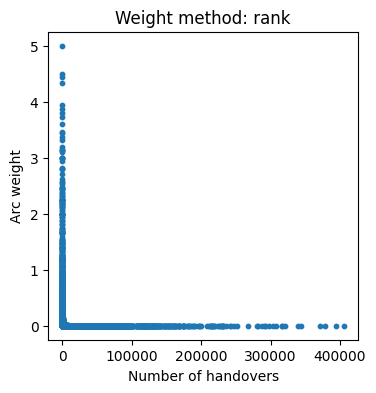

In [15]:
ho_df_day = compute_weight(ho_df_day, METHOD, absolute=ABS, enb_df=enb_df_day)

plt.figure(figsize=(4,4))
plt.title('Weight method: '+METHOD)
plt.scatter(ho_df_day.nbHO15, ho_df_day.Weight, s=10)
plt.xlabel('Number of handovers')
plt.ylabel('Arc weight')

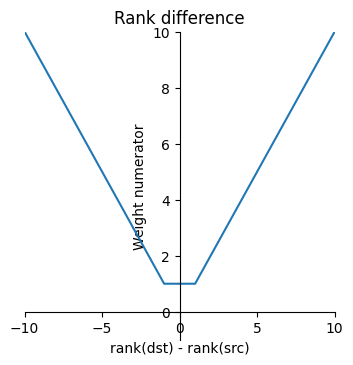

In [15]:
rank_diff = np.arange(-10, 11, 1)
r_src = 0
num = [max(1, abs(r_src-r_dst)) for r_dst in rank_diff]

fig, ax = plt.subplots(figsize=(4,4))
ax.set_title('Rank difference')
ax.plot(rank_diff, num)
ax.set_xlabel('rank(dst) - rank(src)')
ax.set_ylabel('Weight numerator')
ax.set_xlim(-10,10)
ax.set_ylim(-1,10)
ax.spines[["left", "bottom"]].set_position(("data", 0))
ax.spines[["top", "right"]].set_visible(False)


## 3. NetworkX graphs

In [16]:
TOTAL_HO_DAY = int(ho_df_day['nbHO15'].sum())
TOTAL_HO_DAY

78189320

In [17]:
G = nx.from_pandas_edgelist(ho_df_day, source='srcLocInfo', target='dstLocInfo', edge_attr='Weight', create_using=nx.DiGraph)

shortest_paths = []

for i in range(NB_PATHS):
    sp = nx.shortest_path(G, ENB_SRC, ENB_DST, weight='Weight', method='bellman-ford') # Bellman-Ford is better for directed graphs
    shortest_paths.append(sp)
    path_ho = compute_path_ho(ho_df_day, sp)
    traffic = np.round(path_ho/TOTAL_HO_DAY*100,1)
    print('Path length:', len(sp), '\tNumber of handovers:', path_ho, '('+str(traffic)+'%)')
    
    G = update_graph(G, sp, method='half')
    
# Interpolate and smooth
print('\nInterpolating...')
smooth_paths = {}
for i in range(NB_PATHS):
    smooth_paths[i] = smooth_path(shortest_paths[i], enb_df_day, INTERP_COEF)
    print('New path length:', len(smooth_paths[i]))

Path length: 9 	Number of handovers: 598602 (0.8%)
Path length: 9 	Number of handovers: 555249 (0.7%)
Path length: 15 	Number of handovers: 1386981 (1.8%)

Interpolating...
New path length: 15
New path length: 17
New path length: 19


## 4. Folium visualization

In [18]:
lyon = create_map()
folium.TileLayer('CartoDB Positron').add_to(lyon)

colors = ['red', 'purple', 'blue']*2
for i,path in smooth_paths.items():
    add_path(lyon, enb_df_day, path_list=path, name='Path '+str(i), color=colors[i], show_path=False, voronoi=True)
# Adding ground-truth
add_path(lyon, enb_df_day, path_bike[0], name='BIKE', color='red', voronoi=False)
add_path(lyon, enb_df_day, path_car[0], name='CAR 1', color='red', voronoi=False)
add_path(lyon, enb_df_day, path_car[1], name='CAR 2', color='red', voronoi=False)
add_path(lyon, enb_df_day, path_car[2], name='CAR 3', color='red', voronoi=False)
add_path(lyon, enb_df_day, path_car[3], name='CAR 4', color='red', voronoi=False)
add_path(lyon, enb_df_day, path_car[4], name='CAR 5', color='red', voronoi=False)
add_path(lyon, enb_df_day, path_car[5], name='CAR 6', color='red', voronoi=False)
add_path(lyon, enb_df_day, path_tcl[0], name='TCL 1', color='red', voronoi=False)
add_path(lyon, enb_df_day, path_tcl[1], name='TCL 2', color='red', voronoi=False)
add_path(lyon, enb_df_day, path_tcl[2], name='TCL 3', color='red', voronoi=False)

close_map(lyon, 'lyon_shortest_paths_daytime_'+METHOD+'_'+str(ABS)+'.html')
lyon

Creating base station map...
Adding Path layer Path 0
Adding Path layer Path 1
Adding Path layer Path 2
Adding Path layer BIKE
Adding Path layer CAR 1
Adding Path layer CAR 2
Adding Path layer CAR 3
Adding Path layer CAR 4
Adding Path layer CAR 5
Adding Path layer CAR 6
Adding Path layer TCL 1
Adding Path layer TCL 2
Adding Path layer TCL 3
Closing lyon_shortest_paths_daytime_rank_False.html map.


## 5. Ground-truth comparison

In [40]:
path_ref = {
    'BICYCLE': find_closest_enb(path_bike[0], enb_df_day, remove_duplicates=False),
    'CAR_1': find_closest_enb(path_car[0], enb_df_day, remove_duplicates=False),
    'CAR_2': find_closest_enb(path_car[1], enb_df_day, remove_duplicates=False),
    'CAR_3': find_closest_enb(path_car[2], enb_df_day, remove_duplicates=False),
    'CAR_4': find_closest_enb(path_car[3], enb_df_day, remove_duplicates=False),
    'CAR_5': find_closest_enb(path_car[4], enb_df_day, remove_duplicates=False),
    'CAR_6': find_closest_enb(path_car[5], enb_df_day, remove_duplicates=False),
    'TCL_1': find_closest_enb(path_tcl[0], enb_df_day, remove_duplicates=False),
    'TCL_2': find_closest_enb(path_tcl[1], enb_df_day, remove_duplicates=False),
    'TCL_3': find_closest_enb(path_tcl[2], enb_df_day, remove_duplicates=False)
}

In [30]:
def path_coverage(path, ref):
    cell_list = path.LocInfo.tolist()
    outliers = [p for p in ref if p not in cell_list]
    out = len(outliers)
    pos = len(ref)
    return (pos - out) / pos

In [50]:
for k, ref in path_ref.items():
    cov = [path_coverage(smooth_paths[i], ref) for i in smooth_paths.keys()]
    print('Coverage for', k, ':', cov, '\t Maximum:', max(cov))

Coverage for BICYCLE : [0.12087912087912088, 0.14835164835164835, 0.6923076923076923] 	 Maximum: 0.6923076923076923
Coverage for CAR_1 : [0.0796812749003984, 0.2749003984063745, 0.5338645418326693] 	 Maximum: 0.5338645418326693
Coverage for CAR_2 : [0.5706214689265536, 0.5056497175141242, 0.1553672316384181] 	 Maximum: 0.5706214689265536
Coverage for CAR_3 : [0.606508875739645, 0.5236686390532544, 0.09763313609467456] 	 Maximum: 0.606508875739645
Coverage for CAR_4 : [0.7690140845070422, 0.30985915492957744, 0.10140845070422536] 	 Maximum: 0.7690140845070422
Coverage for CAR_5 : [0.05223880597014925, 0.27238805970149255, 0.40298507462686567] 	 Maximum: 0.40298507462686567
Coverage for CAR_6 : [0.3969631236442516, 0.24945770065075923, 0.3839479392624729] 	 Maximum: 0.3969631236442516
Coverage for TCL_1 : [0.7902097902097902, 0.5454545454545454, 0.09090909090909091] 	 Maximum: 0.7902097902097902
Coverage for TCL_2 : [0.8473282442748091, 0.48091603053435117, 0.11450381679389313] 	 Maximum

In [30]:
# Classification
scores = {}
for label, p_ref in path_ref.items():
    sp = {}
    for idx in range(NB_PATHS):
        sp[idx] = path_score(p_ref, smooth_paths[idx].LocInfo.tolist(), enb_df_day)
    scores[label] = sp

print('Precision:')
prec_df = pd.DataFrame(index=range(NB_PATHS), columns=path_ref.keys())
for label, p_ref in path_ref.items():
    for idx in range(NB_PATHS):
        prec_df.loc[idx, label] = scores[label][idx]['Precision']
print(prec_df)

print('\nRecall:')
recl_df = pd.DataFrame(index=range(NB_PATHS), columns=path_ref.keys())
for label, p_ref in path_ref.items():
    for idx in range(NB_PATHS):
        recl_df.loc[idx, label] = scores[label][idx]['Recall']
print(recl_df)

print('\nF1 Score:')
f1_df = pd.DataFrame(index=range(NB_PATHS), columns=path_ref.keys())
for label, p_ref in path_ref.items():
    for idx in range(NB_PATHS):
        f1_df.loc[idx, label] = scores[label][idx]['F1_Score']
print(f1_df)

Precision:
    BICYCLE     CAR_1     CAR_2     CAR_3     CAR_4     CAR_5     CAR_6  \
0  0.133333  0.066667  0.333333  0.333333       0.8  0.066667  0.666667   
1  0.352941  0.294118  0.529412  0.470588  0.294118  0.352941  0.294118   
2  0.157895  0.157895  0.210526  0.052632  0.052632  0.210526  0.263158   

      TCL_1     TCL_2     TCL_3  
0       0.4  0.533333  0.266667  
1  0.470588  0.352941  0.117647  
2  0.052632  0.157895  0.368421  

Recall:
  BICYCLE     CAR_1     CAR_2     CAR_3     CAR_4   CAR_5     CAR_6     TCL_1  \
0   0.125  0.045455  0.178571  0.217391       0.4  0.0625  0.357143  0.315789   
1   0.375  0.227273  0.321429  0.347826  0.166667   0.375  0.178571  0.421053   
2  0.1875  0.136364  0.142857  0.043478  0.033333    0.25  0.178571  0.052632   

      TCL_2   TCL_3  
0  0.421053    0.25  
1  0.315789   0.125  
2  0.157895  0.4375  

F1 Score:
    BICYCLE     CAR_1     CAR_2     CAR_3     CAR_4     CAR_5     CAR_6  \
0  0.129032  0.054054  0.232558  0.263158  0

# NIGHTTIME ANALYSIS
## 1. Import data

### Handover and EnB data

In [58]:
agg_df_night = pd.read_parquet('..\\Processed_data\\HO_AGG_16-22_NIGHTTIME_4G_coords_reduced.snappy.parquet', engine='fastparquet')
ho_df_night = agg_df_night.loc[agg_df_night.srcLocInfo != agg_df_night.dstLocInfo]
ho_df_night

,srcLocInfo,dstLocInfo,nbHO15,srcTechno,srcLON,srcLAT,dstTechno,dstLON,dstLAT
index,,,,,,,,,
144,8102f8100000994e,8102f81000009973,32,4G,4.818062,45.762236,4G,4.822226,45.763890
145,8102f8100000994e,8102f8100000998e,49,4G,4.818062,45.762236,4G,4.826943,45.729725
146,8102f8100000994e,8102f810000099a3,19,4G,4.818062,45.762236,4G,4.845132,45.747557
147,8102f8100000994e,8102f810000099b7,39,4G,4.818062,45.762236,4G,4.832777,45.772496
162,8102f81000009952,8102f81000009963,1785,4G,4.827545,45.752980,4G,4.830520,45.753373
...,...,...,...,...,...,...,...,...,...
5064,8102f8100000bacf,8102f8100000babc,11957,4G,4.867326,45.766061,4G,4.879249,45.766916
5066,8102f8100000bad0,8102f8100000997a,15,4G,4.820179,45.775520,4G,4.802506,45.767224
5067,8102f8100000bad0,8102f810000099c6,1173,4G,4.820179,45.775520,4G,4.829172,45.776392


In [59]:
PATH_TOPO = '..\\..\\Data_Handover\\TOPO\\Lyon\\part-00000-2f038a97-7faf-46f3-aee2-b73b52bf2cba.snappy.parquet'
enb_df_night = pd.read_parquet(PATH_TOPO, engine='fastparquet')
enb_df_night = enb_df_night.loc[enb_df_night['LocInfo'].isin(ho_df_night['srcLocInfo'])].reset_index(drop=True)
#enb_df_night

## 2. Assign node and flow attributes

### Nodes: geographic ranking

In [60]:
enb_df_night = assign_georank(enb_df_night, src_id=ENB_SRC)
enb_df_night

,LocInfo,TECHNO,LON,LAT,Georank
0,8102f8100000999d,4G,4.888138,45.738378,82
1,8102f81000009b28,4G,4.819723,45.771390,37
2,8102f8100000997e,4G,4.875561,45.753615,72
3,8102f81000009976,4G,4.846672,45.729169,42
4,8102f81000009959,4G,4.822966,45.733027,18
...,...,...,...,...,...
179,8102f81000009f4a,4G,4.874679,45.764310,74
180,8102f8100000997b,4G,4.880686,45.725675,76
181,8102f8100000ba70,4G,4.867783,45.701943,71
182,8102f8100000996d,4G,4.864943,45.729614,60


### Flows: handover weight

Text(0, 0.5, 'Arc weight')

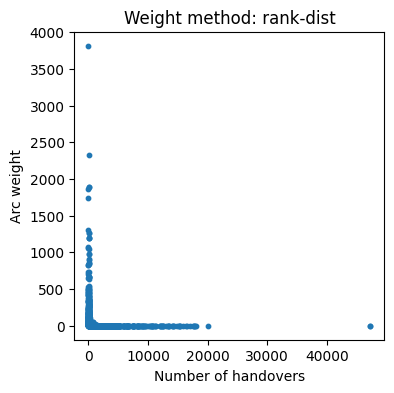

In [85]:
ho_df_night = compute_weight(ho_df_night, METHOD, absolute=ABS, enb_df=enb_df_night)

plt.figure(figsize=(4,4))
plt.title('Weight method: '+METHOD)
plt.scatter(ho_df_night.nbHO15, ho_df_night.Weight, s=10)
plt.xlabel('Number of handovers')
plt.ylabel('Arc weight')

## 3. NetworkX graphs

In [62]:
TOTAL_HO_NIGHT = int(ho_df_night['nbHO15'].sum())
TOTAL_HO_NIGHT

2315427

In [86]:
G = nx.from_pandas_edgelist(ho_df_night, source='srcLocInfo', target='dstLocInfo', edge_attr='Weight', create_using=nx.DiGraph)

shortest_paths = []

for i in range(NB_PATHS):
    sp = nx.shortest_path(G, ENB_SRC, ENB_DST, weight='Weight', method='bellman-ford') # Bellman-Ford is better for directed graphs
    shortest_paths.append(sp)
    path_ho = compute_path_ho(ho_df_night, sp)
    traffic = np.round(path_ho/TOTAL_HO_NIGHT*100,1)
    print('Path length:', len(sp), '\tNumber of handovers:', path_ho, '('+str(traffic)+'%)')
    
    G = update_graph(G, sp, method='half')
    
# Interpolate and smooth
print('\nInterpolating...')
smooth_paths = {}
for i in range(NB_PATHS):
    smooth_paths[i] = smooth_path(shortest_paths[i], enb_df_night, INTERP_COEF)
    print('New path length:', len(smooth_paths[i]))

Path length: 21 	Number of handovers: 76232 (3.3%)
Path length: 20 	Number of handovers: 90438 (3.9%)
Path length: 23 	Number of handovers: 109779 (4.7%)

Interpolating...
New path length: 30
New path length: 27
New path length: 31


## 4. Folium visualization

In [64]:
lyon = create_map()

colors = ['red', 'purple', 'blue']
for i,path in smooth_paths.items():
    add_path(lyon, enb_df_night, path_list=path, name='Path '+str(i), color=colors[i], voronoi=True)
close_map(lyon, 'lyon_shortest_paths_nighttime.html')
lyon

Creating base station map...
Adding Path layer Path 0
Adding Path layer Path 1
Adding Path layer Path 2
Closing lyon_shortest_paths_nighttime.html map.


## 5. Ground-truth comparison

In [87]:
scores = {}
for label, p_ref in path_ref.items():
    sp = {}
    for idx in range(NB_PATHS):
        sp[idx] = path_score(p_ref, smooth_paths[idx].LocInfo.tolist(), enb_df_day)
    scores[label] = sp

print('Precision:')
prec_df = pd.DataFrame(index=range(NB_PATHS), columns=path_ref.keys())
for label, p_ref in path_ref.items():
    for idx in range(NB_PATHS):
        prec_df.loc[idx, label] = scores[label][idx]['Precision']
print(prec_df)

print('\nRecall:')
recl_df = pd.DataFrame(index=range(NB_PATHS), columns=path_ref.keys())
for label, p_ref in path_ref.items():
    for idx in range(NB_PATHS):
        recl_df.loc[idx, label] = scores[label][idx]['Recall']
print(recl_df)

print('\nF1 Score:')
f1_df = pd.DataFrame(index=range(NB_PATHS), columns=path_ref.keys())
for label, p_ref in path_ref.items():
    for idx in range(NB_PATHS):
        f1_df.loc[idx, label] = scores[label][idx]['F1_Score']
print(f1_df)

Precision:
    BICYCLE     CAR_1     CAR_2     TCL_1     TCL_2
0  0.033333       0.1  0.166667  0.166667       0.2
1  0.037037  0.037037  0.037037  0.037037  0.074074
2  0.096774  0.129032  0.193548  0.225806  0.225806

Recall:
  BICYCLE     CAR_1     CAR_2     TCL_1     TCL_2
0  0.0625  0.136364  0.178571  0.263158  0.315789
1  0.0625  0.045455  0.035714  0.052632  0.105263
2  0.1875  0.181818  0.214286  0.368421  0.368421

F1 Score:
    BICYCLE     CAR_1     CAR_2     TCL_1     TCL_2
0  0.043478  0.115385  0.172414  0.204082  0.244898
1  0.046512  0.040816  0.036364  0.043478  0.086957
2   0.12766  0.150943   0.20339      0.28      0.28


(-10000.0, 400000.0)

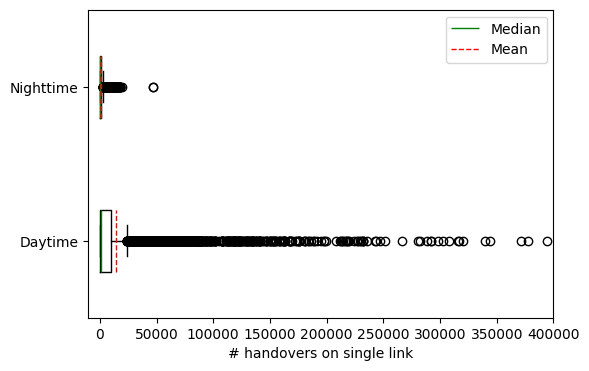

In [26]:
# Distribution of handovers
fig,ax = plt.subplots(figsize=(6,4))
bp = ax.boxplot([agg_df_day.nbHO15, agg_df_night.nbHO15], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'], loc='upper right')
ax.set_yticklabels(['Daytime','Nighttime'])
ax.set_xlabel('# handovers on single link')
ax.set_xlim(-10000, 400000)

(-1000.0, 30000.0)

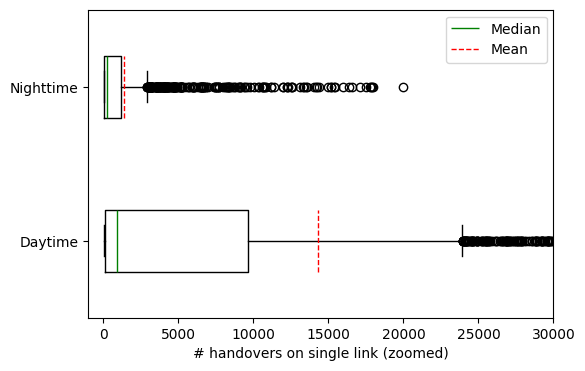

In [27]:
# Distribution of handovers (zoomed)
fig,ax = plt.subplots(figsize=(6,4))
bp = ax.boxplot([agg_df_day.nbHO15, agg_df_night.nbHO15], 
            vert=False, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            medianprops={'color':'green','ls':'-'},
            meanprops={'color':'red','ls':'--'}
            )

ax.legend([bp['medians'][0], bp['means'][0]], ['Median', 'Mean'], loc='upper right')
ax.set_yticklabels(['Daytime','Nighttime'])
ax.set_xlabel('# handovers on single link (zoomed)')
ax.set_xlim(-1000, 30000)